In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        uniques = torch.unique(x, sorted = True)
        for i, v in enumerate(uniques):
            x[x == v] = i
        return x.to(dtype=torch.long)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(), 
        MakeClass()
    ]
)

train_ds = OxfordIIITPet(
    root = "~/data", split = "trainval", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

test_ds = OxfordIIITPet(
    root = "~/data", split = "test", target_types = "segmentation", transform = transform, 
    target_transform = target_transform, 
    download = True
)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

#Training Samples: 3680
#Testing Samples: 3669
#Training Batch: 58
#Testing Batch: 58


In [4]:
sample_data, sample_mask = train_ds[100]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


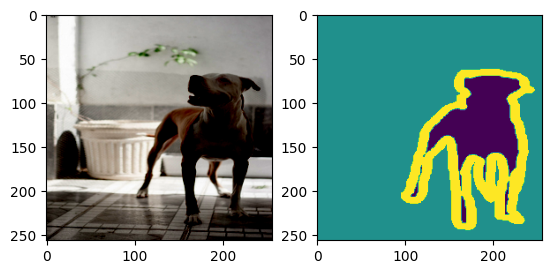

In [5]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(sample_data.cpu().permute(1, -1, 0).numpy())
axarr[1].imshow(sample_mask.cpu().permute(1, -1, 0).numpy())

In [6]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out

In [7]:
class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

In [8]:
class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [9]:
class R2U_Net(nn.Module):
    """https://arxiv.org/abs/1802.06955"""
    def __init__(self, img_ch=3, output_ch=3, t=2, ini_filter = 16):
        super(R2U_Net, self).__init__()

        n1 = ini_filter
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(img_ch, filters[0], t=t)

        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)

        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)

        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)

        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool1(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool2(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool3(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)      

        return out

In [10]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = R2U_Net().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [12]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device, dtype = torch.long)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask.squeeze(1))
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            F.one_hot(train_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(test_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device, dtype = torch.long)
            
            valid_gen_mask = model(valid_img)
            valid_loss = loss_fn(valid_gen_mask, valid_mask.squeeze(1))
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                F.one_hot(valid_mask.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                multiclass=True
            )
            valid_loss = train_rec_loss + train_dice_loss

            va_total_loss += valid_loss.item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(test_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.36it/s]


Epoch: 0 - TrainLoss: 1.187878966331482 - ValidLoss: 1.065565824508667


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.33it/s]


Epoch: 1 - TrainLoss: 0.8760058314635836 - ValidLoss: 0.7578734755516052


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.35it/s]


Epoch: 2 - TrainLoss: 0.7731598615646362 - ValidLoss: 0.6907169818878174


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.42it/s]


Epoch: 3 - TrainLoss: 0.6900019892330828 - ValidLoss: 0.7655328512191772


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.33it/s]


Epoch: 4 - TrainLoss: 0.6381680472143765 - ValidLoss: 0.6012415885925293


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 5 - TrainLoss: 0.6053220475542134 - ValidLoss: 0.6226816773414612


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 6 - TrainLoss: 0.5598268848041008 - ValidLoss: 0.6395844221115112


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 7 - TrainLoss: 0.5292476687965721 - ValidLoss: 0.5263493061065674


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.43it/s]


Epoch: 8 - TrainLoss: 0.5117981526358374 - ValidLoss: 0.477614164352417


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.40it/s]


Epoch: 9 - TrainLoss: 0.49314082850669994 - ValidLoss: 0.4658827483654022


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.35it/s]


Epoch: 10 - TrainLoss: 0.4829587931263036 - ValidLoss: 0.46416038274765015


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.40it/s]


Epoch: 11 - TrainLoss: 0.47830659305227213 - ValidLoss: 0.5297507047653198


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.44it/s]


Epoch: 12 - TrainLoss: 0.43667838388475877 - ValidLoss: 0.43317604064941406


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.26it/s]


Epoch: 13 - TrainLoss: 0.4158736852736309 - ValidLoss: 0.4002149999141693


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 14 - TrainLoss: 0.4133539081647478 - ValidLoss: 0.405735045671463


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.37it/s]


Epoch: 15 - TrainLoss: 0.38648452378552534 - ValidLoss: 0.3745284676551819


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 16 - TrainLoss: 0.3965207564419714 - ValidLoss: 0.3929201066493988


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.09it/s]


Epoch: 17 - TrainLoss: 0.39074419901288787 - ValidLoss: 0.4348031282424927


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.39it/s]


Epoch: 18 - TrainLoss: 0.3660585756959586 - ValidLoss: 0.4133295714855194


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 19 - TrainLoss: 0.3560013745365472 - ValidLoss: 0.3886905610561371


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.33it/s]


Epoch: 20 - TrainLoss: 0.3435546673577407 - ValidLoss: 0.3638867139816284


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.36it/s]


Epoch: 21 - TrainLoss: 0.3399954083664664 - ValidLoss: 0.3682866394519806


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.27it/s]


Epoch: 22 - TrainLoss: 0.33793852760873994 - ValidLoss: 0.30704158544540405


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.35it/s]


Epoch: 23 - TrainLoss: 0.31914995096880816 - ValidLoss: 0.288484662771225


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.17it/s]


Epoch: 24 - TrainLoss: 0.31292166637963265 - ValidLoss: 0.3329737186431885


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.45it/s]


Epoch: 25 - TrainLoss: 0.31761736140168945 - ValidLoss: 0.2999471127986908


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.26it/s]


Epoch: 26 - TrainLoss: 0.31337584503765764 - ValidLoss: 0.3116103410720825


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.42it/s]


Epoch: 27 - TrainLoss: 0.30412460195607155 - ValidLoss: 0.2959415912628174


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 28 - TrainLoss: 0.2905589182829035 - ValidLoss: 0.2956940531730652


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 29 - TrainLoss: 0.2853583559907716 - ValidLoss: 0.285317599773407


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.19it/s]


Epoch: 30 - TrainLoss: 0.27502655006688215 - ValidLoss: 0.2914661765098572


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 31 - TrainLoss: 0.26301050186157227 - ValidLoss: 0.2782254219055176


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.39it/s]


Epoch: 32 - TrainLoss: 0.2653154766765134 - ValidLoss: 0.2846648097038269


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.39it/s]


Epoch: 33 - TrainLoss: 0.26717552054544974 - ValidLoss: 0.25441235303878784


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  4.93it/s]


Epoch: 34 - TrainLoss: 0.2630219868031041 - ValidLoss: 0.27518197894096375


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 35 - TrainLoss: 0.26372338985574656 - ValidLoss: 0.25819793343544006


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 36 - TrainLoss: 0.2559870956786748 - ValidLoss: 0.27090299129486084


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 37 - TrainLoss: 0.24553315084556054 - ValidLoss: 0.2501676082611084


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 38 - TrainLoss: 0.23244675582852856 - ValidLoss: 0.21914876997470856


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 39 - TrainLoss: 0.2297021505133859 - ValidLoss: 0.24882438778877258


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.35it/s]


Epoch: 40 - TrainLoss: 0.23023572255825175 - ValidLoss: 0.2390851527452469


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.04it/s]


Epoch: 41 - TrainLoss: 0.22373213002393985 - ValidLoss: 0.22414126992225647


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.37it/s]


Epoch: 42 - TrainLoss: 0.22654903243327962 - ValidLoss: 0.2175418585538864


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 43 - TrainLoss: 0.22098273141630764 - ValidLoss: 0.2321513593196869


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 44 - TrainLoss: 0.21363795702827387 - ValidLoss: 0.20851600170135498


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 45 - TrainLoss: 0.20924920614423423 - ValidLoss: 0.20163078606128693


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 46 - TrainLoss: 0.20177506424229721 - ValidLoss: 0.2192068099975586


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 47 - TrainLoss: 0.19776358224194626 - ValidLoss: 0.20659728348255157


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.41it/s]


Epoch: 48 - TrainLoss: 0.19486691802740097 - ValidLoss: 0.1869158148765564


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 49 - TrainLoss: 0.19257312833235182 - ValidLoss: 0.2012469619512558


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 50 - TrainLoss: 0.19866632053564334 - ValidLoss: 0.19539478421211243


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 51 - TrainLoss: 0.1870086470554615 - ValidLoss: 0.20080305635929108


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 52 - TrainLoss: 0.18256911892315436 - ValidLoss: 0.173635333776474


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.35it/s]


Epoch: 53 - TrainLoss: 0.179086869646763 - ValidLoss: 0.15839025378227234


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 54 - TrainLoss: 0.175646862850107 - ValidLoss: 0.18543188273906708


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 55 - TrainLoss: 0.17633558886832204 - ValidLoss: 0.1778869479894638


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.02it/s]


Epoch: 56 - TrainLoss: 0.17441718819840202 - ValidLoss: 0.18648311495780945


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 57 - TrainLoss: 0.1695168950948222 - ValidLoss: 0.1797342151403427


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 58 - TrainLoss: 0.16580785451264218 - ValidLoss: 0.16995769739151


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 59 - TrainLoss: 0.1628209213758337 - ValidLoss: 0.17554479837417603


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 60 - TrainLoss: 0.1613643097466436 - ValidLoss: 0.1800292581319809


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 61 - TrainLoss: 0.15921909233619427 - ValidLoss: 0.15407073497772217


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 62 - TrainLoss: 0.15681626313719257 - ValidLoss: 0.15823063254356384


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.37it/s]


Epoch: 63 - TrainLoss: 0.15494076753484792 - ValidLoss: 0.14783620834350586


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.08it/s]


Epoch: 64 - TrainLoss: 0.15133768833916764 - ValidLoss: 0.16052624583244324


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.36it/s]


Epoch: 65 - TrainLoss: 0.14884269545818196 - ValidLoss: 0.1440136432647705


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.29it/s]


Epoch: 66 - TrainLoss: 0.1477979419046435 - ValidLoss: 0.15674284100532532


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 67 - TrainLoss: 0.1511261558224415 - ValidLoss: 0.16319632530212402


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.36it/s]


Epoch: 68 - TrainLoss: 0.146005944702132 - ValidLoss: 0.17300188541412354


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 69 - TrainLoss: 0.14296331821844496 - ValidLoss: 0.14257076382637024


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.22it/s]


Epoch: 70 - TrainLoss: 0.14051009200770279 - ValidLoss: 0.14495615661144257


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 71 - TrainLoss: 0.13803193538353362 - ValidLoss: 0.13843604922294617


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 72 - TrainLoss: 0.13701928471182956 - ValidLoss: 0.14592799544334412


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.36it/s]


Epoch: 73 - TrainLoss: 0.13470352055697604 - ValidLoss: 0.159948468208313


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.26it/s]


Epoch: 74 - TrainLoss: 0.1335100549562224 - ValidLoss: 0.12835246324539185


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 75 - TrainLoss: 0.13267063927547684 - ValidLoss: 0.1484028697013855


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 76 - TrainLoss: 0.13095968524957524 - ValidLoss: 0.13436704874038696


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.16it/s]


Epoch: 77 - TrainLoss: 0.12934415170858646 - ValidLoss: 0.12750431895256042


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 78 - TrainLoss: 0.1282739571199335 - ValidLoss: 0.1366729736328125


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 79 - TrainLoss: 0.12681950204845133 - ValidLoss: 0.14081421494483948


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.43it/s]


Epoch: 80 - TrainLoss: 0.12562059598236247 - ValidLoss: 0.12343451380729675


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 81 - TrainLoss: 0.12452132948513689 - ValidLoss: 0.11449217796325684


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.34it/s]


Epoch: 82 - TrainLoss: 0.12487078496608241 - ValidLoss: 0.14699698984622955


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.37it/s]


Epoch: 83 - TrainLoss: 0.12321658727937732 - ValidLoss: 0.13943353295326233


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.25it/s]


Epoch: 84 - TrainLoss: 0.12182519058215208 - ValidLoss: 0.12195949256420135


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.27it/s]


Epoch: 85 - TrainLoss: 0.12245126839341788 - ValidLoss: 0.1477091908454895


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 86 - TrainLoss: 0.11993615213653137 - ValidLoss: 0.1307574212551117


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 87 - TrainLoss: 0.12008207137214727 - ValidLoss: 0.12070654332637787


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 88 - TrainLoss: 0.1190829483856415 - ValidLoss: 0.1236468106508255


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 89 - TrainLoss: 0.11879083462830248 - ValidLoss: 0.11908949911594391


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 90 - TrainLoss: 0.11908237327789438 - ValidLoss: 0.12796401977539062


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.36it/s]


Epoch: 91 - TrainLoss: 0.11743823451728656 - ValidLoss: 0.12234380841255188


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.28it/s]


Epoch: 92 - TrainLoss: 0.117459776714958 - ValidLoss: 0.12757143378257751


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.30it/s]


Epoch: 93 - TrainLoss: 0.11704569733862219 - ValidLoss: 0.12426640838384628


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 94 - TrainLoss: 0.11702320673342409 - ValidLoss: 0.11546880006790161


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.35it/s]


Epoch: 95 - TrainLoss: 0.1166244639918722 - ValidLoss: 0.11426714062690735


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 96 - TrainLoss: 0.11650480843823531 - ValidLoss: 0.12627780437469482


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.31it/s]


Epoch: 97 - TrainLoss: 0.11652215210528209 - ValidLoss: 0.11095651239156723


100%|██████████████████████████████████████████████████████| 58/58 [00:11<00:00,  5.27it/s]


Epoch: 98 - TrainLoss: 0.11659585954300289 - ValidLoss: 0.1291624903678894


100%|██████████████████████████████████████████████████████| 58/58 [00:10<00:00,  5.32it/s]


Epoch: 99 - TrainLoss: 0.11701989045430874 - ValidLoss: 0.1259590983390808


<All keys matched successfully>

  0%|                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 10%|█████▌                                                 | 1/10 [00:00<00:01,  7.46it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 20%|███████████                                            | 2/10 [00:00<00:01,  6.85it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0

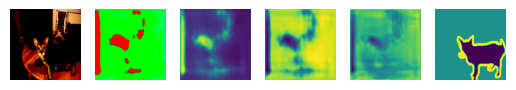

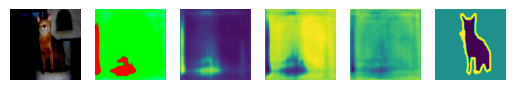

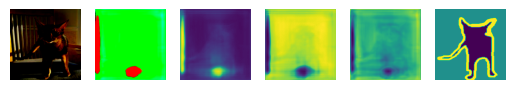

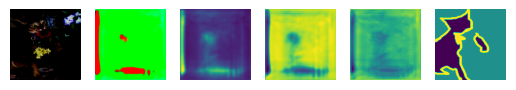

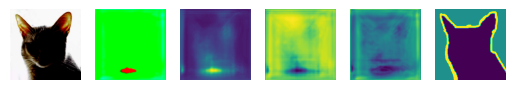

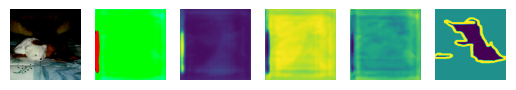

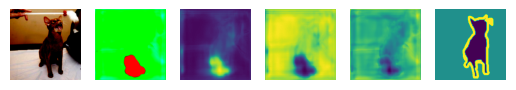

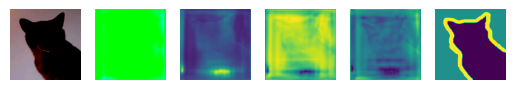

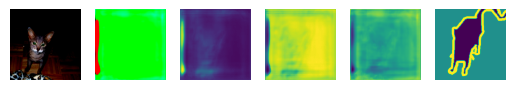

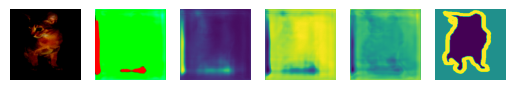

In [13]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     

        f, axarr = plt.subplots(1, 6)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(gen_mask[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(gen_mask[0][0].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        axarr[3].imshow(gen_mask[0][1].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[3].axis('off')
        axarr[4].imshow(gen_mask[0][2].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        axarr[4].axis('off')
        axarr[5].imshow(valid_mask.cpu().permute(1, -1, 0).numpy())
        axarr[5].axis('off')